In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt


class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)  # 0: empty, 1: X, -1: O
        self.done = False
        self.winner = None

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.done = False
        self.winner = None
        return self.board.flatten()  # Return flattened board for the neural network

    def available_actions(self):
        return list(zip(*np.where(self.board == 0)))  # List of (row, col) for empty spaces

    def take_action(self, action, player):
        if self.board[action] == 0:
            self.board[action] = player
            if self.check_winner(player):
                self.done = True
                self.winner = player
            elif len(self.available_actions()) == 0:
                self.done = True  # Draw
            return self.board.flatten(), self.done, self.winner
        return self.board.flatten(), False, None

    def check_winner(self, player):
        for i in range(3):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        if np.all(np.diagonal(self.board) == player) or np.all(np.diagonal(np.fliplr(self.board)) == player):
            return True
        return False

    def render(self):
        print(self.board)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent:
    def __init__(self, input_size, output_size, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99, batch_size=64):
        self.model = DQN(input_size, output_size)
        self.target_model = DQN(input_size, output_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.memory = deque(maxlen=2000)
        self.optimizer = optim.Adam(self.model.parameters())
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.batch_size = batch_size
        self.update_target_frequency = 10
        self.steps_done = 0

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(9))  # Random action
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decrease_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [ ]:
def train(agent, episodes=1000):
    env = TicTacToe()
    episode_rewards = []  # List to store the total reward of each episode
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0  # Total reward for the current episode
        
        while not done:
            action = agent.act(state)
            row, col = divmod(action, 3)
            next_state, done, winner = env.take_action((row, col), player=1)

            reward = 1 if winner == 1 else (-1 if winner == -1 else 0)

            agent.store_experience(state, action, reward, next_state, done)
            agent.experience_replay()

            state = next_state
            total_reward += reward  # Accumulate reward

        agent.decrease_epsilon()

        if episode % agent.update_target_frequency == 0:
            agent.update_target_model()

        # Log the total reward for this episode
        episode_rewards.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}, Epsilon: {agent.epsilon:.2f}, Total Reward: {total_reward}")

    # Plot the learning curve after training is complete
    plt.plot(episode_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve of DQN for Tic-Tac-Toe')
    plt.show()


Episode 0, Epsilon: 0.99, Total Reward: 1


C:\Users\HP\AppData\Local\Temp\ipykernel_15160\2919770299.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 100, Epsilon: 0.60, Total Reward: 1
Episode 200, Epsilon: 0.37, Total Reward: 1
Episode 300, Epsilon: 0.22, Total Reward: 1
Episode 400, Epsilon: 0.13, Total Reward: 1
Episode 500, Epsilon: 0.08, Total Reward: 1
Episode 600, Epsilon: 0.05, Total Reward: 1
Episode 700, Epsilon: 0.03, Total Reward: 1
Episode 800, Epsilon: 0.02, Total Reward: 1
Episode 900, Epsilon: 0.01, Total Reward: 1


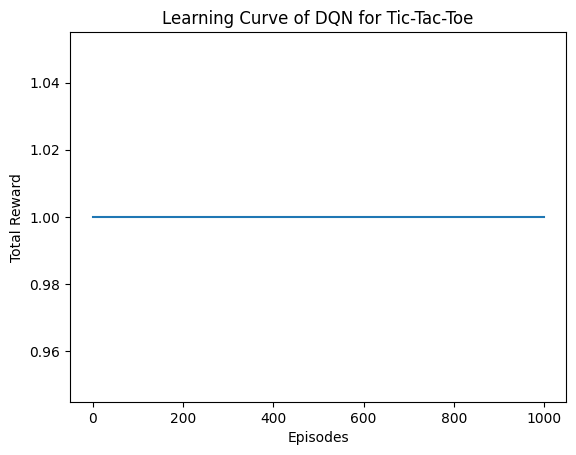

In [4]:
train(Agent(input_size=9, output_size=9), episodes=1000)